In [1]:
from sklearn.model_selection import train_test_split
from typing import List

import pandas as pd
import numpy as np

RANDOM_SEED: int = 42

df = pd.read_csv("../datasets/diamonds/preprocessed/diamonds_encoded.csv")

# Split the data into 80% training and 20% testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

FEATURE_NAMES: List[str] = train_df.drop(['price'], axis=1).columns.tolist()

# training data
X_train = train_df[FEATURE_NAMES].to_numpy()
y_train = train_df['price'].to_numpy()

# testing data
X_test = test_df[FEATURE_NAMES].to_numpy()
y_test = test_df['price'].to_numpy()

X_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train, y_test))

Create a simple Linear Regression on the training data and generate prices predictions for the test data with it.

In [2]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

predictions = lr_model.predict(X_test)

Show the predicted prices compared to the actual ones in the test data.

In [3]:
test_df = test_df[[col for col in test_df.columns if col != 'price'] + ['price']]
test_df['predicted_price'] = predictions
test_df

carat  cut  color  clarity  depth  table     x     y     z  price  \
1839   0.32    4     21        3   62.1   56.0  4.43  4.40  2.74    900   
1536   1.15    3     19        2   62.2   56.0  6.76  6.68  4.18   5851   
1662   0.50    2     21        2   60.7   61.0  5.09  5.12  3.10   1316   
1075   1.53    2     18        3   60.9   63.0  7.37  7.41  4.50  11452   
4201   1.01    3     20        4   62.4   61.0  6.39  6.36  3.98   7127   
...     ...  ...    ...      ...    ...    ...   ...   ...   ...    ...   
2503   1.01    2     19        3   59.1   58.0  6.56  6.63  3.90   5919   
4849   0.72    2     19        5   62.2   57.0  5.67  5.72  3.54   2933   
4905   0.36    4     21        4   61.8   56.0  4.60  4.56  2.83   1094   
191    1.02    4     21        3   60.7   56.0  6.58  6.61  4.00   6704   
1723   0.38    4     22        4   62.0   55.0  4.64  4.68  2.89   1067   

      predicted_price  
1839       578.533505  
1536      6108.645110  
1662      1204.959334  
1075      9902.232938  
4201      6220.427812  
...               ...  
2503      5511.808207  
4849      3912.658117  
4905      1365.747466  
191       6430.228528  
1723      1985.846820  

[998 rows x 11 columns]

Before proceeding with experimenting different model, we define the metrics we want to use to evaluate the performance of different models and find which one's predictions are closest to the expected values.

- Mean Squared Error (MSE).
- Root Mean Squared Error (RMSE).
- Mean Absolute Error (MAE).
- Coefficient of Determination ($R^2$).

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(test_prices, predictions):
	
	mae = mean_absolute_error(test_prices, predictions)
	mse = mean_squared_error(test_prices, predictions)
	rmse = np.sqrt(mse)
	r2 = r2_score(test_prices, predictions)
	
	return { 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2 }

evaluate_model(y_test, predictions)


{'MAE': 836.9251628403184,
 'MSE': 1564212.5522539152,
 'RMSE': 1250.684833302905,
 'R2': 0.8955416611586824}

Now that we have a way to compare models' performance let's evaluate a different one: the Decision Tree.

In [5]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(max_depth=3)
dt_model.fit(X_train, y_train)

predictions = dt_model.predict(X_test)

metrics = evaluate_model(y_test, predictions)

metrics

{'MAE': 792.7007022650636,
 'MSE': 1952635.5351491114,
 'RMSE': 1397.3673586960272,
 'R2': 0.8696027185881491}

We can tune some hyperparameters, like `max_depth` to change the maximum depth of the tree, and eventually obtain better performance.

In [6]:
max_depths_to_evaluate = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 50, 100, 150]
results = list()

for max_depth in max_depths_to_evaluate:
    # Train a decision tree model
    dt_model = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_SEED)
    dt_model.fit(X_train, y_train)
    # Make predictions using the model on the testing set
    predictions = dt_model.predict(X_test)
    # Compute and store some metrics to evaluate the model
    metrics = evaluate_model(y_test, predictions)
    results.append((max_depth, metrics['MAE'], metrics['MSE'], metrics['RMSE'], metrics['R2']))

results_dt_df = pd.DataFrame(results, columns=['max_depth', 'MAE', 'MSE', 'RMSE', 'R^2'])
results_dt_df

max_depth         MAE           MSE         RMSE       R^2
0           3  792.700702  1.952636e+06  1397.367359  0.869603
1           4  667.909911  1.405434e+06  1185.509922  0.906145
2           5  564.644131  9.940306e+05   997.010821  0.933618
3           6  505.044273  8.605693e+05   927.668744  0.942531
4           7  453.413192  6.711382e+05   819.230242  0.955181
5           8  443.396607  7.222620e+05   849.860017  0.951767
6           9  440.307709  7.582901e+05   870.798539  0.949361
7          10  446.383118  8.493325e+05   921.592350  0.943281
8          11  458.375031  9.018788e+05   949.672996  0.939772
9          12  465.489222  8.883716e+05   942.534693  0.940674
10         13  464.451296  9.283364e+05   963.502169  0.938006
11         14  485.200005  9.621607e+05   980.897906  0.935747
12         15  474.535426  9.192468e+05   958.773584  0.938613
13         20  476.481105  9.252405e+05   961.894223  0.938212
14         50  467.402806  9.340082e+05   966.441000  0.937627
15        100  467.402806  9.340082e+05   966.441000  0.937627
16        150  467.402806  9.340082e+05   966.441000  0.937627

In [7]:
def find_best_model(results_df: pd.DataFrame, model_name: str, hparameters: List[str], min_metrics = ["MAE", "MSE", "RMSE"], max_metrics = ["R^2"]) -> None:
    for metric in min_metrics:
        best_index = results_df[metric].idxmin()
        best_model = results_df.loc[best_index, [*hparameters, metric]]
        print(f"Best performing {model_name} on {metric}:")
        print(best_model.to_string(name=False), end="\n\n")
        
    for metric in max_metrics:
        best_index = results_df[metric].idxmax()
        best_model = results_df.loc[best_index, [*hparameters, metric]]
        print(f"Best performing {model_name} on {metric}:")
        print(best_model.to_string(name=False), end="\n\n")

find_best_model(results_dt_df, model_name=type(dt_model).__name__, hparameters=["max_depth"])

Best performing DecisionTreeRegressor on MAE:
max_depth      9.000000
MAE          440.307709

Best performing DecisionTreeRegressor on MSE:
max_depth         7.000000
MSE          671138.188987

Best performing DecisionTreeRegressor on RMSE:
max_depth      7.000000
RMSE         819.230242

Best performing DecisionTreeRegressor on R^2:
max_depth    7.000000
R^2          0.955181



### K-fold Cross Validation

When evaluating different hyperparameters of a ML model there is a risk of overfitting because the parameters may have been tweaked on the test set until we have the optimal configuration.
One way to avoid this problem could be to hold out another portion of the original dataset as "validation set" and perform experiments on that before the test set.

Otherwise we can perform a K-fold Cross Validation, in which we split the whole dataset in K subsets and then for each of the _k_ "folds":
1. the model is trained using the other $k-1$ folds as training data
2. the evaluation is performed on the remaining part of the data (the left out fold)

In [8]:
from sklearn.model_selection import cross_validate

def evaluate_model_cv(model, X, y, cv=10):
	cv_results = cross_validate(model, X, y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])
 
	metrics = {
		'MAE': -cv_results['test_neg_mean_absolute_error'],
		'MSE': -cv_results['test_neg_mean_squared_error'],
		'RMSE': np.sqrt(-cv_results['test_neg_mean_squared_error']),
		'R^2': cv_results['test_r2']
	}
 
	metrics_mean = {
		'MAE': metrics['MAE'].mean(),
		'MSE': metrics['MSE'].mean(),
		'RMSE': metrics['RMSE'].mean(),
		'R^2': metrics['R^2'].mean()
	}
 
	return cv_results, metrics_mean, metrics

Let's take as a reference the 2 best performing configurations of the `DecisionTreeRegressor` model:

In [9]:
results_dt_df[(results_dt_df['max_depth'] == 7) | (results_dt_df['max_depth'] == 9)]

max_depth         MAE            MSE        RMSE       R^2
4          7  453.413192  671138.188987  819.230242  0.955181
6          9  440.307709  758290.095031  870.798539  0.949361

We perform the K-fold CV with $k=10$, first with `DecisionTreeRegressor(max_depth=7)` and then with `max_depth=9`.

In [10]:
dt_model = DecisionTreeRegressor(max_depth=7, random_state=RANDOM_SEED)

cv_results, metrics_mean, metrics = evaluate_model_cv(dt_model, X_all, y_all)

pd.DataFrame(metrics)

MAE            MSE        RMSE       R^2
0  470.149255  749137.468348  865.527278  0.955045
1  440.027756  534009.319777  730.759413  0.964817
2  469.218257  656462.634515  810.223818  0.957672
3  447.228215  737727.097739  858.910413  0.952394
4  496.285074  744199.575638  862.670027  0.951607
5  491.582390  786857.166394  887.049698  0.950494
6  503.783769  971928.655106  985.864420  0.942919
7  513.378736  884193.634587  940.315710  0.946312
8  502.414062  909176.798727  953.507629  0.943621
9  470.534189  744134.166342  862.632115  0.946184

In [11]:
print(pd.Series(metrics_mean).add_prefix('Average ').to_string(name=False))

Average MAE        480.460170
Average MSE     771782.651717
Average RMSE       875.746052
Average R^2          0.951107


In this first case the average performance computed during the cross validation is both worse than the previously trained model's scores with the same configuration and also worse than the second one.

It is very likely that in this setting we were overfitting on the test set!

In [12]:
dt_model = DecisionTreeRegressor(max_depth=9, random_state=RANDOM_SEED)

cv_results, metrics_mean, metrics = evaluate_model_cv(dt_model, X_all, y_all)

pd.DataFrame(metrics)

MAE            MSE        RMSE       R^2
0  438.279167  746181.543217  863.818004  0.955222
1  358.228929  408277.819745  638.966212  0.973101
2  389.605121  479970.886319  692.799312  0.969052
3  399.166625  685391.078586  827.883493  0.955772
4  445.574291  711186.907021  843.318983  0.953754
5  435.388816  679367.054800  824.237256  0.957257
6  434.399398  820333.021685  905.722376  0.951823
7  454.110851  826556.751529  909.151666  0.949812
8  464.328431  908431.006928  953.116471  0.943667
9  438.217390  760557.851800  872.099680  0.944996

In [13]:
print(pd.Series(metrics_mean).add_prefix('Average ').to_string(name=False))

Average MAE        425.729902
Average MSE     702625.392163
Average RMSE       833.111345
Average R^2          0.955446


When performing the cross validation with the second configuration instead, we can easily notice that this time the average performance is better on all the metrics when using the same parameters and it is also even better or close to the performance of the first configuration.

Therefore this setting is the one to go with!

### Models interpretation

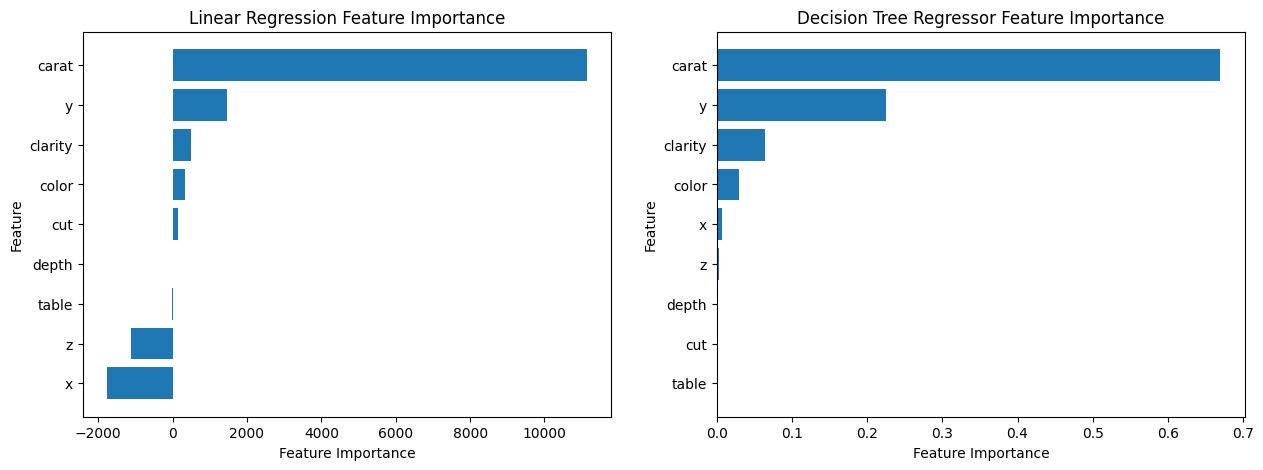

In [14]:
import matplotlib.pyplot as plt

dt_model = DecisionTreeRegressor(max_depth=9, random_state=RANDOM_SEED)
dt_model.fit(X_all, y_all)

dt_feature_importance = dt_model.feature_importances_
dt_sorted_features = [feature for _, feature in sorted(zip(dt_feature_importance, FEATURE_NAMES))]

lr_model = LinearRegression()
lr_model.fit(X_all, y_all)

lr_feature_importance = lr_model.coef_
lr_sorted_features = [feature for _, feature in sorted(zip(lr_feature_importance, FEATURE_NAMES))]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].barh(lr_sorted_features, sorted(lr_feature_importance))
axes[0].set_xlabel('Feature Importance')
axes[0].set_ylabel('Feature')
axes[0].set_title('Linear Regression Feature Importance')

axes[1].barh(dt_sorted_features, sorted(dt_feature_importance))
axes[1].set_xlabel('Feature Importance')
axes[1].set_ylabel('Feature')
axes[1].set_title('Decision Tree Regressor Feature Importance')

plt.show()

Moreover, with Decision Trees we have another way to visualize and interpret the predictions, which is visualizing the builded tree itself.

For the sake of simplicity we plot a small tree of `max_depth=4` just to go over the process of explaining the why behind every price tag as requested by the demanding clientele.

In [15]:
import dtreeviz

dt_model = DecisionTreeRegressor(max_depth=4, random_state=RANDOM_SEED)
dt_model.fit(X_all, y_all)

viz = dtreeviz.model(dt_model, X_all, y_all,
                     target_name="price",
                     feature_names=FEATURE_NAMES)

viz.view(scale=1.6)

Let's show a step-by-step example of reasoning the price tag of a certain diamond based on this plot.

| carat	| cut  | color | clarity | depth | table | x	| y    | z	  | price |
|-------|------|-------|---------|-------|-------|------|------|------|-------|
| 1.15	| 3	   | 19	   | 2       | 62.2	 | 56.0	 | 6.76	| 6.68 | 4.18 |	5851  |

Given the characteristics of the above diamond, we start from the root of the tree and ask:
1. "is the **Carat** greater than 0.995?"
   - since the answer is _Yes_ we proceed on the right branch
2. on the right branch we want to know whether the **y** dimension of the diamond is greater than 7.215 or not
   - since the answer is _No_ we proceed on the left branch this time
3. now the decision is made based on the **Clarity** of the diamond, is it greater than 3.5?
   - since the answer is _No_ we proceed on the left branch
4. the final decision defining the price is again based on the diamond's Clarity:
   1. if the clarity is greater than 2.5 then the price would be 6611.69
   2. otherwise, the price would be 4940.35

So, since the Clarity of the diamond is 2 we arrived at the conclusion that the predicted price tag of this model is **4940.35**.

And we can tell the buyer that the price is based on the fact that:
1. carat   > 0.995
2. y       > 7.215
3. clarity <= 2.5

More accurate predictions can be obtained with the best Decision Tree model with max depth of 9, which plot is saved locally as an svg.

In [16]:
dt_model = DecisionTreeRegressor(max_depth=9, random_state=RANDOM_SEED)
dt_model.fit(X_all, y_all)

viz = dtreeviz.model(dt_model, X_all, y_all,
                     target_name="price",
                     feature_names=FEATURE_NAMES)

viz.view(scale=1).save("../img/diamonds_decision_tree.svg")

### Bonus: exploration of more complex models

In [17]:
from sklearn.ensemble import RandomForestRegressor

max_depths_to_evaluate = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 50]
n_estimators_to_evaluate = [2, 5, 10, 15, 20, 25, 50, 75, 100, 200]

results = []

for max_depth in max_depths_to_evaluate:
    for n_estimators in n_estimators_to_evaluate:
        model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=RANDOM_SEED)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        metrics = evaluate_model(y_test, predictions)
        results.append((max_depth, n_estimators, metrics['MAE'], metrics['MSE'], metrics['RMSE'], metrics['R2']))

results_rf_df = pd.DataFrame(results, columns=['max_depth', 'n_estimators', 'MAE', 'MSE', 'RMSE', 'R^2'])
results_rf_df

max_depth  n_estimators         MAE           MSE         RMSE       R^2
0            3             2  762.956753  1.846987e+06  1359.039027  0.876658
1            3             5  744.949995  1.779365e+06  1333.928411  0.881174
2            3            10  725.315891  1.693327e+06  1301.278878  0.886919
3            3            15  720.029597  1.682482e+06  1297.105195  0.887644
4            3            20  715.535485  1.659406e+06  1288.179152  0.889185
..         ...           ...         ...           ...          ...       ...
145         50            25  357.999158  5.259426e+05   725.219004  0.964877
146         50            50  354.159259  5.104396e+05   714.450566  0.965913
147         50            75  353.049686  5.153969e+05   717.911460  0.965582
148         50           100  351.197355  5.153542e+05   717.881778  0.965585
149         50           200  350.292590  5.149422e+05   717.594753  0.965612

[150 rows x 6 columns]

In [18]:
find_best_model(results_rf_df, model_name=type(model).__name__, hparameters=["max_depth", "n_estimators"])

Best performing RandomForestRegressor on MAE:
max_depth        20.000000
n_estimators    200.000000
MAE             348.239143

Best performing RandomForestRegressor on MSE:
max_depth           10.000000
n_estimators        50.000000
MSE             496075.033206

Best performing RandomForestRegressor on RMSE:
max_depth        10.000000
n_estimators     50.000000
RMSE            704.325942

Best performing RandomForestRegressor on R^2:
max_depth       10.000000
n_estimators    50.000000
R^2              0.966872



In [22]:
model = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=RANDOM_SEED)

cv_results, metrics_mean, metrics = evaluate_model_cv(model, X_all, y_all)

print(pd.Series(metrics_mean).add_prefix('Average ').to_string(name=False))

Average MAE        327.466747
Average MSE     435498.330577
Average RMSE       657.689783
Average R^2          0.972364


In [23]:
model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=RANDOM_SEED)

cv_results, metrics_mean, metrics = evaluate_model_cv(model, X_all, y_all)

print(pd.Series(metrics_mean).add_prefix('Average ').to_string(name=False))

Average MAE        337.801365
Average MSE     443271.286569
Average RMSE       663.238139
Average R^2          0.971896
